In [1]:
import os
import struct
import shutil
import cv2
import numpy as np
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import exposure,io, color, feature
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score
from sklearn.utils import shuffle

In [43]:
def load_images_from_folder(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Add more file extensions as needed
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            
            # Assuming you have a naming convention where the class label is in the filename
            label = filename.split('_')[0]  # Modify this based on your naming convention
            
            # Remove non-alphabetic characters from the label
            label = ''.join(filter(str.isalpha, label))
            
            if img is not None:
                images.append(img)
                labels.append(label)

    return images, labels

def preprocess_images(images):
    processed_images = []
    for img in images:
        # Convert to grayscale
        grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize the grayscale image to 96x96 pixels
        resized_img = cv2.resize(grayscale_img, (96, 96))
        
        # Flatten the image
        flattened_img = resized_img.flatten()
        
        processed_images.append(flattened_img)
    
    return np.array(processed_images)


folder_path = 'STL-10/labeled images/'
images, labels = load_images_from_folder(folder_path)

processed_images = preprocess_images(images)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

df = pd.DataFrame(processed_images)
df['label'] = encoded_labels

csv_filename = 'output_data.csv'
df.to_csv(csv_filename, index=False)

In [2]:
sheet = pd.read_csv('output_data.csv')
sheet.head()

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,label
0,173,181,182,173,170,177,168,126,183,183,...,96,95,93,91,86,82,85,85,81,0
1,152,139,127,129,135,141,151,160,169,179,...,122,133,138,143,147,146,143,139,131,0
2,155,183,150,132,141,111,82,66,62,72,...,136,138,151,163,155,146,147,115,137,0
3,103,104,107,107,104,99,96,91,89,89,...,64,67,76,80,77,76,78,76,71,0
4,114,96,187,215,180,183,202,149,144,123,...,29,31,28,28,28,25,30,29,31,0


In [3]:
sheet.info()
sheet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Columns: 9217 entries, 0 to label
dtypes: int64(9217)
memory usage: 182.8 MB


,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,label
count,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,...,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000
mean,97.458846,99.136154,99.631923,99.565000,99.823077,100.259231,100.822692,100.927308,101.258846,101.150769,...,85.136538,85.243462,85.325769,85.463077,85.262692,85.203077,84.866154,84.708846,84.055385,0.500000
std,79.238856,79.426590,79.514216,79.290498,79.204205,79.172950,79.228808,79.114378,79.177420,79.062385,...,68.025233,68.198968,68.401985,68.523106,68.215899,68.330486,68.490253,68.842373,68.958832,0.500096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,5.000000,6.000000,...,15.000000,14.000000,14.750000,13.000000,11.750000,10.000000,9.750000,8.000000,7.000000,0.000000
50%,99.000000,101.000000,102.000000,103.000000,103.500000,103.500000,104.000000,106.000000,104.500000,105.000000,...,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,84.000000,83.000000,0.500000
75%,162.000000,163.000000,163.000000,163.000000,165.000000,164.250000,165.000000,166.000000,165.000000,165.000000,...,135.000000,136.000000,136.000000,136.000000,136.000000,138.000000,136.000000,137.000000,135.000000,1.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,1.000000


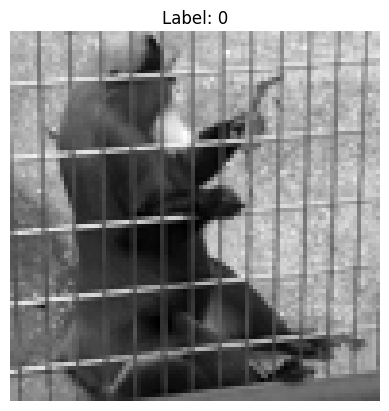

In [5]:
first_image = np.array(sheet.iloc[0, :-1]).reshape(96, 96)  # Assuming images are 96x96 pixels with 1 channel
plt.imshow(first_image, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title(f'Label: {sheet.iloc[0, -1]}')
plt.axis('off')
plt.show()

In [6]:
# Extract features (X) and labels (y)
X = sheet.drop('label', axis=1)  # Assuming the label column is named 'label'
y = sheet['label']

In [7]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,173,181,182,173,170,177,168,126,183,183,...,95,96,95,93,91,86,82,85,85,81
1,152,139,127,129,135,141,151,160,169,179,...,109,122,133,138,143,147,146,143,139,131
2,155,183,150,132,141,111,82,66,62,72,...,137,136,138,151,163,155,146,147,115,137
3,103,104,107,107,104,99,96,91,89,89,...,62,64,67,76,80,77,76,78,76,71
4,114,96,187,215,180,183,202,149,144,123,...,30,29,31,28,28,28,25,30,29,31


In [8]:
means = []
stds = []

for col in X.columns:
    avg = X[col].mean()
    sd = X[col].std()
    
    # Normalize the column in-place
    X[col] = X[col].apply(lambda x: (x - avg) / sd)
    
    # Append means and stds to lists
    means.append(avg)
    stds.append(sd)

# Convert means and stds lists to NumPy arrays if needed
means_array = np.array(means)
stds_array = np.array(stds)

In [9]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,0.953335,1.030686,1.035891,0.926151,0.886025,0.969280,0.847890,0.316917,1.032380,1.035249,...,0.139124,0.159698,0.143060,0.112193,0.080804,0.010808,-0.046876,0.001954,0.004229,-0.044307
1,0.688313,0.501895,0.344191,0.371230,0.444129,0.514579,0.633322,0.746675,0.855562,0.984656,...,0.345075,0.541909,0.700253,0.770069,0.839672,0.905028,0.889748,0.848790,0.788630,0.680763
2,0.726173,1.055866,0.633447,0.409065,0.519883,0.135662,-0.237574,-0.441479,-0.495834,-0.368706,...,0.756976,0.747715,0.773568,0.960122,1.131544,1.022303,0.889748,0.907193,0.440007,0.767771
3,0.069930,0.061237,0.092664,0.093769,0.052736,-0.015905,-0.060870,-0.125480,-0.154828,-0.153686,...,-0.346331,-0.310716,-0.267503,-0.136338,-0.079726,-0.121126,-0.134685,-0.100250,-0.126504,-0.189321
4,0.208751,-0.039485,1.098773,1.455849,1.012281,1.045064,1.277027,0.607635,0.539815,0.276354,...,-0.817075,-0.825231,-0.795371,-0.838072,-0.838594,-0.839433,-0.881057,-0.801080,-0.809223,-0.769378


In [11]:
stds_array

array([79.23885603, 79.42659016, 79.51421562, ..., 68.49025292,
       68.84237254, 68.95883205])

In [12]:
km = KMeans(n_clusters=2,n_init = 10,random_state=101)
X['cluster'] = km.fit_predict(X)

C:\Users\Dell\AppData\Local\Temp\ipykernel_1764\3693771721.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['cluster'] = km.fit_predict(X)


In [13]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,cluster
0,0.953335,1.030686,1.035891,0.926151,0.886025,0.969280,0.847890,0.316917,1.032380,1.035249,...,0.159698,0.143060,0.112193,0.080804,0.010808,-0.046876,0.001954,0.004229,-0.044307,1
1,0.688313,0.501895,0.344191,0.371230,0.444129,0.514579,0.633322,0.746675,0.855562,0.984656,...,0.541909,0.700253,0.770069,0.839672,0.905028,0.889748,0.848790,0.788630,0.680763,1
2,0.726173,1.055866,0.633447,0.409065,0.519883,0.135662,-0.237574,-0.441479,-0.495834,-0.368706,...,0.747715,0.773568,0.960122,1.131544,1.022303,0.889748,0.907193,0.440007,0.767771,0
3,0.069930,0.061237,0.092664,0.093769,0.052736,-0.015905,-0.060870,-0.125480,-0.154828,-0.153686,...,-0.310716,-0.267503,-0.136338,-0.079726,-0.121126,-0.134685,-0.100250,-0.126504,-0.189321,0
4,0.208751,-0.039485,1.098773,1.455849,1.012281,1.045064,1.277027,0.607635,0.539815,0.276354,...,-0.825231,-0.795371,-0.838072,-0.838594,-0.839433,-0.881057,-0.801080,-0.809223,-0.769378,0


In [14]:
X['cluster']

0       1
1       1
2       0
3       0
4       0
       ..
2595    0
2596    0
2597    0
2598    1
2599    1
Name: cluster, Length: 2600, dtype: int32

In [15]:
counter = np.sum(y!= X['cluster'])

In [16]:
y

0       0
1       0
2       0
3       0
4       0
       ..
2595    1
2596    1
2597    1
2598    1
2599    1
Name: label, Length: 2600, dtype: int64

In [17]:
counter

781

In [18]:
((2600-counter)/2600)*100

69.96153846153847

In [22]:
# Load and resize the image
image = cv2.imread('monkey.jpg')
target_size = (96, 96)
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), target_size)

# Normalize and flatten the image
flattened_image = resized_image.flatten()
    
# Reshape the flattened image to a 2D array
normalized_image = (flattened_image - means_array) / stds_array

# Reshape the flattened image to a 2D array
reshaped_image = normalized_image.reshape(1, -1)

# Make predictions
predictions = km.predict(reshaped_image)

print(predictions)

[0]


C:\Users\Dell\anaconda3\envs\djangoenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [20]:
flattened_image

array([129, 134, 132, ...,  90,  84,  89], dtype=uint8)